In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/neural_machine_translation

/content/drive/My Drive/Colab Notebooks/neural_machine_translation


In [3]:
!pip install sacrebleu

In [4]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, print_function, division
import string
import random
from data_utils import *
from rnn import *
import torch
import codecs
from tqdm import tqdm
import string
import heapq

#Set GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load vocabulary files
input_lang = torch.load('data-bin/fra.data')
output_lang = torch.load('data-bin/eng.data')

#Create and empty RNN model
encoder = EncoderRNN(input_size=input_lang.n_words, device=device)
attn_decoder = AttnDecoderRNN(output_size=output_lang.n_words, device=device)

#Load the saved model weights into the RNN model
encoder.load_state_dict(torch.load('model/encoder'))
attn_decoder.load_state_dict(torch.load('model/decoder'))

#Return the decoder output given input sentence
#Additionally, the previous predicted word and previous decoder state can also be given as input
def translate_single_word(encoder, decoder, sentence, decoder_input=None, decoder_hidden=None, max_length=MAX_LENGTH, device=device):

    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, device)
        input_length = input_tensor.size()[0]

        encoder = encoder.to(device)
        decoder = decoder.to(device)

        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        if decoder_input==None:
            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        else:
            decoder_input = torch.tensor([[output_lang.word2index[decoder_input]]], device=device)

        if decoder_hidden == None:
            decoder_hidden = encoder_hidden

        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        return decoder_output.data, decoder_hidden


# It reads hardcoded sentences as input, translates using the trained RNN and saves the outputs in example.txt file.
def translate_example():

    target_sentences = ["i can speak a bit of french .",
        "i ve bought some cheese and milk .",
        "boy where is your older brother ?",
        "i ve just started reading this book .",
        "she loves writing poems ."]

    source_sentences = ["je parle un peu francais .",
          "j ai achete du fromage et du lait .",
          "garcon ou est ton grand frere ?",
          "je viens justement de commencer ce livre .",
          "elle adore ecrire des poemes ."]

    target = codecs.open('example.txt','w',encoding='utf-8')

    beam_size = 1

    for i, source_sentence in enumerate(source_sentences):

        target_sentence = normalizeString(target_sentences[i])
        input_sentence = normalizeString(source_sentence)

        hypothesis = beam_search(encoder, attn_decoder, input_sentence, beam_size=beam_size)

        print("S-"+str(i)+": "+input_sentence)
        print("T-"+str(i)+": "+target_sentence)
        print("H-"+str(i)+": "+hypothesis)
        print()
        target.write(hypothesis+'\n')

    target.close()


###################################################################################################################
###Part 1. Write the function below to read the data/test.fra file and write the translations in test_beam_1.out###
###################################################################################################################

def load_text_file(file_path):

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    return [line.strip() for line in lines]

def normalizeString(s):

    # Normalize a string by converting to lowercase and removing unnecessary characters

    s = s.lower().strip()

    # Remove any non-alphanumeric characters (except for basic punctuation)
    s = ''.join(char if char.isalnum() or char in string.punctuation + ' ' else ' ' for char in s)

    # Remove extra whitespaces
    s = ' '.join(s.split())

    return s

def translate_test():

    # Load target and source sentences
    target_sentences = load_text_file('data/test.eng')
    source_sentences = load_text_file('data/test.fra')

    # Open file for writing beam search output
    target = codecs.open('test_beam_1.out','w',encoding='utf-8')

    # Set beam size
    beam_size = 1

    # Loop through source sentences
    for i, source_sentence in enumerate(source_sentences):

        # Normalize target and input sentences
        target_sentence = normalizeString(target_sentences[i])
        input_sentence = normalizeString(source_sentence)

        # Perform beam search for translation
        hypothesis = beam_search(encoder, attn_decoder, input_sentence, beam_size=beam_size)

        # Print and write results
        print("S-"+str(i)+": " + input_sentence)
        print("T-"+str(i)+": " + target_sentence)
        print("H-"+str(i)+": " + hypothesis)
        print()
        target.write(hypothesis+'\n')

    # Close the output file
    target.close()

    # Compute BLEU score
    !sacrebleu data/test.eng < test_beam_1.out

#############################################################################################
###Part 2. Modify this function to use beam search to predict instead of greedy prediction###
#############################################################################################

def beam_search(encoder, decoder, input_sentence, beam_size=1, max_length=MAX_LENGTH):

    # Predicted the first word
    decoder_output, decoder_hidden = translate_single_word(encoder, decoder, input_sentence, decoder_input=None, decoder_hidden=None)

    # Get the probability of all output words
    decoder_output_probs = decoder_output.data

    # Get the top beam_size indices and their probabilities
    top_probs, top_idx = torch.topk(decoder_output_probs, beam_size)

    # Initialize the beams with the top beam_size candidates
    beams = [([output_lang.index2word[idx.item()]], decoder_hidden, top_probs[0, i].item()) for i, idx in enumerate(top_idx[0])]

    # Loop until the maximum length
    for i in range(max_length - 1):  # Subtract 1 to account for the initial word
        new_beams = []
        for beam in beams:
            # Extract the last predicted word and hidden state
            previous_decoded_output = beam[0][-1]
            decoder_hidden = beam[1]

            # Predict the next word given the previous prediction and the previous decoder hidden state
            try:
                decoder_output, decoder_hidden = translate_single_word(encoder, decoder, input_sentence, previous_decoded_output, decoder_hidden)
            except KeyError:
                # Handle the case when the special token is not found in word2index
                continue

            # Get the probability of all output words
            decoder_output_probs = decoder_output.data

            # Get the top beam_size indices and their probabilities
            top_probs, top_idx = torch.topk(decoder_output_probs, beam_size)

            # Extend each beam with the top beam_size candidates
            for idx, prob in zip(top_idx[0], top_probs[0]):
                new_beam = (beam[0] + [output_lang.index2word[idx.item()]], decoder_hidden, beam[2] + prob.item())
                new_beams.append(new_beam)

        # Select the top beam_size candidates among all beams without sorting the entire list
        new_beams.sort(key=lambda x: x[2], reverse=True)
        beams = new_beams[:beam_size]

        # Check for the end of sentence in the current beams
        eos_found = any(word == "EOS" for word in beams[0][0])
        if eos_found:
            break

    # Select the best beam as the final prediction
    best_beam = max(beams, key=lambda x: x[2])
    output_translation = " ".join(word for word in best_beam[0])

    return output_translation

print(translate_test())



S-0: je t aime !
T-0: i love you !
H-0: i m coming love . EOS

S-1: fais tout ce qu il te dit .
T-1: do whatever he tells you .
H-1: you re what that to have you . EOS

S-2: c est difficile d avoir des idees geniales .
T-2: it s difficult to have great ideas .
H-2: he is full of of . . . EOS

S-3: je me suis etendu sur l herbe .
T-3: i laid myself on the grass .
H-3: i m the one who understands . EOS

S-4: je vais acheter une nouvelle voiture .
T-4: i am going to buy a new car .
H-4: i m going to buy a new car . EOS

S-5: je suis tres sensible a la chaleur .
T-5: i am very sensitive to heat .
H-5: i m very sensitive to heat . EOS

S-6: mes parents m adorent .
T-6: i m loved by my parents .
H-6: i am fond of my parents . EOS

S-7: j etais en mission a l etranger .
T-7: i was abroad on an assignment .
H-7: i m going to abroad . . EOS

S-8: je m interesse a la natation .
T-8: i am interested in swimming .
H-8: i am interested in politics . EOS

S-9: j ai un ordinateur .
T-9: i have a comp

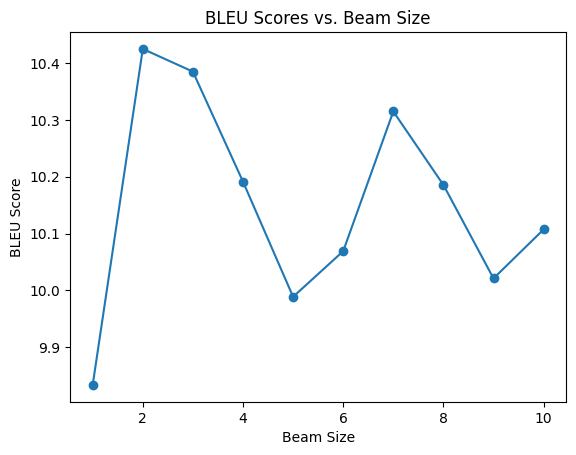

In [5]:
#############################################################################################
###Part 3. Tune beam size on valid.fra & plot BLEU scores###
#############################################################################################

import matplotlib.pyplot as plt
import sacrebleu

# Function to compute BLEU score using sacrebleu
def compute_bleu(reference_file, hypothesis_file):

    with open(reference_file, 'r', encoding='utf-8') as ref_file:
        references = [line.strip() for line in ref_file.readlines()]

    with open(hypothesis_file, 'r', encoding='utf-8') as hyp_file:
        hypotheses = [line.strip() for line in hyp_file.readlines()]

    bleu = sacrebleu.corpus_bleu(hypotheses, [references])
    return bleu.score

# Function to plot BLEU scores
def plot_bleu_scores(beam_sizes, bleu_scores):

    plt.plot(beam_sizes, bleu_scores, marker='o')
    plt.title('BLEU Scores vs. Beam Size')
    plt.xlabel('Beam Size')
    plt.ylabel('BLEU Score')
    plt.show()

# Function to tune and plot beam size
def tune_and_plot_beam_size(encoder, decoder, source_file, reference_file, max_beam_size):

    beam_sizes = list(range(1, max_beam_size + 1))
    bleu_scores = []

    # Precompute normalized sentences
    normalized_sentences = [normalizeString(sentence) for sentence in load_text_file(source_file)]

    for beam_size in beam_sizes:

        hypothesis_file = f'valid_beam_{beam_size}.out'

        with open(hypothesis_file, 'w', encoding='utf-8') as target:

            for i, source_sentence in enumerate(normalized_sentences):

                # Exclude 'EOS' from the input sentence
                input_sentence = ' '.join(word for word in source_sentence.split() if word != 'EOS')

                hypothesis = beam_search(encoder, decoder, input_sentence, beam_size=beam_size)
                target.write(hypothesis+'\n')

        # Compute BLEU score for the current beam size
        bleu = compute_bleu(reference_file, hypothesis_file)
        bleu_scores.append(bleu)

    # Find the optimal beam size
    optimal_beam_size = beam_sizes[bleu_scores.index(max(bleu_scores))]

    # Plot the BLEU scores
    plot_bleu_scores(beam_sizes, bleu_scores)

    return optimal_beam_size

# Get the optimal beam size from tuning
optimal_beam_size = tune_and_plot_beam_size(encoder, attn_decoder, 'data/valid.fra', 'data/valid.eng', max_beam_size=10)

In [6]:
#############################################################################################
###Part 4. Compute BLEU score for test.fra file using optimal beam size###
#############################################################################################

def apply_beam_search_test(encoder, decoder, source_file, optimal_beam_size):

    # Open the file for writing hypotheses
    with open('test_beam_k.out', 'w', encoding='utf-8') as target:

        # Precompute normalized sentences
        normalized_sentences = [normalizeString(sentence) for sentence in load_text_file(source_file)]

        # Iterate over each sentence in the test set
        for i, source_sentence in enumerate(normalized_sentences):

            # Exclude 'EOS' from the input sentence
            input_sentence = ' '.join(word for word in source_sentence.split() if word != 'EOS')

            # Apply beam search to generate a hypothesis
            hypothesis = beam_search(encoder, decoder, input_sentence, beam_size=optimal_beam_size)

            # Write the hypothesis to the output file
            target.write(hypothesis+'\n')

# Apply beam search on the test set with the optimal beam size
apply_beam_search_test(encoder, attn_decoder, 'data/test.fra', optimal_beam_size)

# Compute BLEU score
!sacrebleu data/test.eng < test_beam_k.out

{
 "name": "BLEU",
 "score": 10.8,
 "signature": "nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.4.0",
 "verbose_score": "36.4/12.0/6.9/4.6 (BP = 1.000 ratio = 1.179 hyp_len = 7329 ref_len = 6218)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.4.0"
}
